# Method Comparison and Interpretability using GPR with homoscedastic noise
This notebook compares several methods for incorporating theory into machine learning. The problem at hand is predicting the log of the Radius of Gyration squared ($R_g^2$) for coarse-grain polymers of different lengths ($N$) and different solvent qualities (parameterized by $\alpha$). As a machine learning model, we use Gaussian Process Regression with homoscedastic noise. Known uncertainties computed from the simulations are ignored. We use the squared exponential kernel. Since we are predicting the log of the Radius of Gyration squared in the thermodynamic limit, we expect a single value as an output given a set of input parameters. However, if you plan to model a system where the output will be a distribution rather than a single value, you will need to modify the notebook accordingly such as by adding a White kernel. For more details see the SI of !FILL IN DOI ONCE PUBLISHED!, which compares GPR with heteroscedastic noise with GPR with homoscedastic noise with random forest.

## For Google Colab
For running the code in Google Colab, GPFlow must first be installed. This can be accomplished by uncommenting the code block below, executing it, and restarting the Runtime (there should be a button at the bottom of the output of the code block. The notebook can then be run as normal.

In [ ]:
# !pip install gpflow==2.2.1

# Dependencies

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import warnings
import gpflow
from gpflow.ci_utils import ci_niter
import tensorflow as tf
from gpflow.utilities import print_summary, set_trainable
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Set up the plotting settings

In [2]:
cmap = sns.color_palette("colorblind")
markers = ['o', 'v', 'p', '^', 'h', '<', 's', '>']

# Helper function: Model optimization to determine the best hyperparameters

In [3]:
def optimizeGPR(model, niter=5000):
    """
    Perform model (hyperparameter) optimization for GPR using Adam as implemented
    in TensorFlow. A stochastic optimizer helps to reduce getting stuck in a local
    minimum.
    """

    adam = tf.optimizers.Adam(learning_rate=0.01)

    minimum = model.training_loss().numpy()
    minmodelparam = gpflow.utilities.read_values(model)

    print_summary(model)

    @tf.function
    def step(i):
        adam.minimize(model.training_loss, model.trainable_variables)

    for i in tf.range(ci_niter(niter)):
        step(i)

    for i in tf.range(ci_niter(100)):
        step(i)

        # keep track of the actual minimum to eliminate error from unstable optimization
        if model.training_loss().numpy() < minimum:
            minimum = model.training_loss().numpy()
            minmodelparam = gpflow.utilities.read_values(model)

    gpflow.utilities.multiple_assign(model, minmodelparam)
    print_summary(model)
    print("Maximum Likelihood is", -1*model.training_loss().numpy())

    return model

# The theory

In [4]:
def calc_rg(N):
    return N/6.

# Get the data and select a subset for training v. testing

In [5]:
# Load the data
df = pd.read_csv('../data/Rgmaindata.csv')

x = np.array(df[['log N', 'lambda']])
y = np.array(df['log Rg,mean'])
a = np.array(df['log Rg, var err'])
t = np.log(calc_rg(np.exp(x[:, 0]))).reshape(len(x[:, 0]))

# Create a train and test set
indices = np.arange(len(y))
random.seed(10)  # set seed for reproducibility
random.shuffle(indices)

# Create a train and test set

# Select test and train sets based a specific case that was run using the source code for consistancy.
train = [19, 78, 17, 22, 77, 35, 53, 109, 96, 39, 81, 95, 14, 44, 3, 133, 27, 106, 124, 20, 63, 75,
         91, 6, 140, 48, 84, 137, 18, 42]  # , 0, 9, 111, 2, 119, 67, 58, 139, 83, 121, 126, 45, 61, 130]
test = [41, 97, 47, 52, 73, 138, 128, 129, 68, 125, 57, 56, 87, 72, 13, 134, 50, 104, 89, 100, 98, 79, 107,
        51, 12, 15, 32, 131, 110, 16, 43, 92, 114, 26, 122, 135, 132, 70, 40, 33, 28, 10, 103, 101, 117, 30,
        55, 37, 113, 99, 80, 94, 24, 36, 93, 127, 66, 49, 102, 54, 82, 115, 71, 105, 34, 5, 74, 65, 11, 86,
        76, 120, 59, 116, 69, 85, 141, 31, 145, 62, 64, 143, 108, 144, 46, 142, 38, 118, 123, 88, 136, 7, 4,
        60, 90, 25, 21, 8, 23, 1, 29, 112]

# If you would like to randomly select the test and train, which should give qualitatively similar results, use:
# indices=np.arange(len(y))
# random.seed(10) # set seed for reproducibility
# random.shuffle(indices)
# train=indices[0:30]
# test=indices[31:]

x_train = x[train]
y_train = y[train].reshape(-1, 1)
alpha_train = a[train].reshape(-1, 1)
t_train = t[train].reshape(-1, 1)
ymean = y[train].mean()
yvar = y[train].var()

x_test = x[test]
y_test = y[test].reshape(-1, 1)
t_test = t[test].reshape(-1, 1)

# Load outlier data, too
dfout = pd.read_csv('../data/Rgoutlierdata.csv')

x_out = np.array(dfout[['log N', 'lambda']])
y_out = np.array(dfout['log Rg,mean']).reshape(-1, 1)
t_out = np.log(calc_rg(np.exp(x_out[:, 0]))).reshape(
    len(x_out[:, 0])).reshape(-1, 1)

# Run the different methods

## Direct Model
This has no knowledge of the theory and uses GPR to predict $\ln R_g^2$ as a function of $\ln N$ and $\alpha$ (solvent quality).

In [6]:
# define
kernel = gpflow.kernels.SquaredExponential(lengthscales=[3, 0.1])
model_direct = gpflow.models.GPR((x_train, y_train), kernel=kernel,
                                 mean_function=gpflow.mean_functions.Constant(y_train.mean()))

# optimize
model_direct = optimizeGPR(model_direct)

# test
y_mean, y_var = model_direct.predict_f(x_test)
mse_direct = mean_squared_error(y_test, y_mean)

y_mean, y_var = model_direct.predict_f(x_out)
mse_out_direct = mean_squared_error(y_out, y_mean)

2022-05-05 20:42:46.037916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 20:42:46.080394: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ 2.227866036917798 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0               │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [3.  0.1]         │
├───────────────

## Theory method
This has no knowledge of the data. $\ln R_g^2$ is computed as $\ln N + 1/6$. Note that it completely ignores solvent quality ($\alpha$).


In [7]:
# test
mse_theory = mean_squared_error(y_test, t_test)
mse_out_theory = mean_squared_error(y_out, t_out)

## Difference method
Learn the difference between the test data and the theory using GPR. The input to the GPR is $\ln N$ and $\alpha$ (solvent quality). The output is $\ln R_g^2$ from the data set minus the predicted $\ln R_g^2$ from theory. To make predictions for $\ln R_g^2$ for new input, the predicted theory needs to be added to the output of the GPR.

In [8]:
# define
kernel = gpflow.kernels.SquaredExponential(lengthscales=[3, 0.1])
model_diff = gpflow.models.GPR((x_train, y_train-t_train), kernel=kernel,
                               mean_function=gpflow.mean_functions.Constant(y_train.mean()-t_train.mean()))

# optimize
model_diff = optimizeGPR(model_diff)

# test
y_mean, y_var = model_diff.predict_f(x_test)
y_mean += t_test
mse_diff = mean_squared_error(y_test, y_mean)

y_mean, y_var = model_diff.predict_f(x_out)
y_mean += t_out
mse_out_diff = mean_squared_error(y_out, y_mean)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -0.25478210730714324 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0                  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [3.  0.1]      

## Parameterization method
Incorporate the functional form of the theory through $\ln R_g^2 = 2\nu[\alpha] \ln N + \kappa[\alpha,\ln N]$ As written, both $\nu$ and $\kappa$ are Gaussian Processes. However, these two Gaussian Processes can be combined to yield a single Gaussian process. See the SI of !FILL IN DOI ONCE PUBLISHED!. Also see Eq. 2.8-2.11 and 2.21 in https://www.cs.toronto.edu/~duvenaud/thesis.pdf for the rules of Gaussian Processes that enable this to be done.

In [9]:
# kernel for the constant term
kernel1 = gpflow.kernels.SquaredExponential(lengthscales=[3, .1])

# kernel for the function
kernel2 = gpflow.kernels.Linear(active_dims=[0])
kernel2.variance.assign(1)

# kernel for the slope
kernel3 = gpflow.kernels.SquaredExponential(lengthscales=[3], active_dims=[1])

# total kernel
kernel = kernel2*kernel3+kernel1

model_param = gpflow.models.GPR(
    (x_train, y_train-t_train), kernel=kernel, mean_function=gpflow.mean_functions.Constant())

# fix one of the two prefactors that are multiplied by each other
set_trainable(model_param.kernel.kernels[0].kernels[0].variance, False)

# optimize
model_param = optimizeGPR(model_param)

# test
y_mean, y_var = model_param.predict_f(x_test)
y_mean += t_test
mse_param = mean_squared_error(y_test, y_mean)

y_mean, y_var = model_param.predict_f(x_out)
y_mean += t_out
mse_out_param = mean_squared_error(y_out, y_mean)

╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value     │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.mean_function.c                           │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.]      │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[0].kernels[0].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0       │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[0].kernels[1].varian

# Look at the results

## Create a table of the mean squared error

In [10]:
tabledata = {'Method': ["Direct", "Theory", "Difference", "Parameterization"],
             "MSE_test": [mse_direct, mse_theory, mse_diff, mse_param],
             "MSE_outlier": [mse_out_direct, mse_out_theory, mse_out_diff, mse_out_param]}
dftable = pd.DataFrame(data=tabledata)
dftable.head()

,Method,MSE_test,MSE_outlier
0,Direct,0.011634,0.062764
1,Theory,1.056213,3.533054
2,Difference,0.017171,0.244289
3,Parameterization,0.006005,0.053117


## Look at the predictions

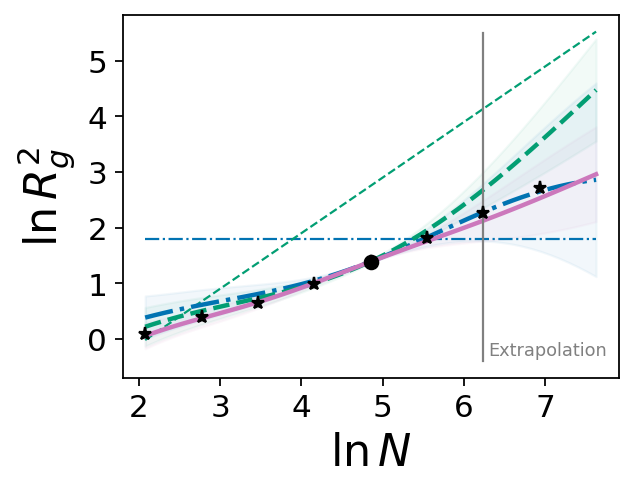

<Figure size 432x288 with 0 Axes>

In [11]:
figure(figsize=(4, 3), dpi=160)

lamb = 1.  # pick a value of lambda to look at


# compute the predictions
xx = np.array([np.linspace(np.log(8), np.log(1024*2), 50),
              np.ones(50)*lamb]).transpose()

mean_direct, var_direct = model_direct.predict_f(xx)

mean_diff, var_diff = model_diff.predict_f(xx)
mean_diff = mean_diff.numpy() + xx[:, 0].reshape(1, -1).transpose()+np.log(1/6)

mean_param, var_param = model_param.predict_f(xx)
mean_param = mean_param.numpy(
) + xx[:, 0].reshape(1, -1).transpose()+np.log(1/6)

# Plot the priors
plt.plot(xx[:, 0], model_direct.mean_function.c.numpy()+xx[:, 0]
         * 0, "-.", color=cmap[0], lw=1, label='Direct prior')
plt.plot(xx[:, 0], model_diff.mean_function.c.numpy()+np.log(1/6) +
         xx[:, 0], "--", color=cmap[2], lw=1, label='Difference prior')

# plot the predictions
plt.plot(xx[:, 0], mean_direct, '-.', color=cmap[0], lw=2, label='direct')
plt.plot(xx[:, 0], mean_diff, '--', color=cmap[2], lw=2, label='difference')
plt.plot(xx[:, 0], mean_param, color=cmap[4], lw=2, label='parameterization')

plt.fill_between(
    xx[:, 0],
    mean_direct[:, 0] - 1.96 * np.sqrt(var_direct[:, 0]),
    mean_direct[:, 0] + 1.96 * np.sqrt(var_direct[:, 0]),
    color=cmap[0],
    alpha=0.05,
)
plt.fill_between(
    xx[:, 0],
    mean_diff[:, 0] - 1.96 * np.sqrt(var_diff[:, 0]),
    mean_diff[:, 0] + 1.96 * np.sqrt(var_diff[:, 0]),
    color=cmap[2],
    alpha=0.05,
)
plt.fill_between(
    xx[:, 0],
    mean_param[:, 0] - 1.96 * np.sqrt(var_param[:, 0]),
    mean_param[:, 0] + 1.96 * np.sqrt(var_param[:, 0]),
    color=cmap[4],
    alpha=0.05,
)

# Plot extrapolation line
plt.plot([np.log(512), np.log(512)], [-.4, 5.5], "-",
         color='grey', lw=1, label='Difference prior')
plt.text(6.3, -.3, 'Extrapolation', color='grey', fontsize=8)

# Plot the data
datalam = pd.concat([df[df['lambda'] == lamb], dfout[dfout['lambda'] == lamb]])
dftrain = df.iloc[train]
datatrainlam = dftrain[dftrain['lambda'] == lamb]

plt.plot(datalam['log N'], datalam['log Rg,mean'], '*', c='black')
plt.plot(datatrainlam['log N'], datatrainlam['log Rg,mean'], 'o', c='black')

# Add labels, etc.
plt.xlabel(r'$\ln N$', fontsize=20)
plt.ylabel(r'$\ln R_g^2$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()
plt.savefig('data_homo.pdf', bbox_inches='tight')

# Look at interpretability

## Difference method
Here we plot the predicted difference. When this difference is approximately zero, the theory accurately predicts the true data. With such a small dataset size, the theory is normally but not always accurate within uncertainty. If we focus on the mean of the predictions, we find it is accurate near but not exactly at the theta point. This is because the prefactor on the theory is not exact at the theta point.

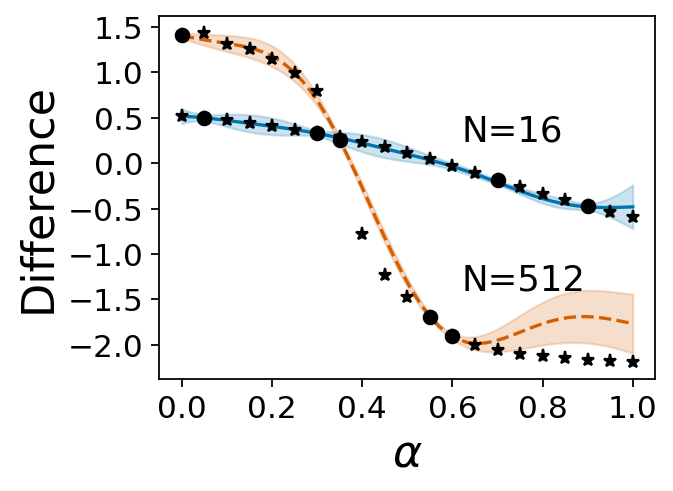

<Figure size 432x288 with 0 Axes>

In [12]:
figure(figsize=(4, 3), dpi=160)

Xn16 = np.array([np.ones(50)*np.log(16), np.linspace(0, 1, 50)]).transpose()
Yn16, Vn16 = model_diff.predict_f(Xn16)

Xn512 = np.array([np.ones(50)*np.log(512), np.linspace(0, 1, 50)]).transpose()
Yn512, Vn512 = model_diff.predict_f(Xn512)

plt.plot(Xn16[:, 1], Yn16, color=cmap[0], label='N=16')
plt.fill_between(
    Xn16[:, 1],
    (Yn16[:, 0] - 1.96 * np.sqrt(Vn16[:, 0])),
    (Yn16[:, 0] + 1.96 * np.sqrt(Vn16[:, 0])),
    color=cmap[0],
    alpha=0.2,
)
plt.plot(Xn512[:, 1], Yn512, '--', color=cmap[3], label='N=512')
plt.fill_between(
    Xn512[:, 1],
    (Yn512[:, 0] - 1.96 * np.sqrt(Vn512[:, 0])),
    (Yn512[:, 0] + 1.96 * np.sqrt(Vn512[:, 0])),
    color=cmap[3],
    alpha=0.2,
)

set16 = df[df['log N'] == np.log(16)]
set512 = df[df['log N'] == np.log(512)]
plt.plot(set16['lambda'], set16['log Rg,mean'] -
         np.log(16)-np.log(1/6), '*', c='black')
plt.plot(set512['lambda'], set512['log Rg,mean'] -
         np.log(512)-np.log(1/6), '*', c='black')

dftrain = df.iloc[train]
datatrain16 = dftrain[dftrain['log N'] == np.log(16)]
datatrain512 = dftrain[dftrain['log N'] == np.log(512)]
plt.plot(datatrain16['lambda'], datatrain16['log Rg,mean'] -
         np.log(16)-np.log(1/6), 'o', c='black')
plt.plot(datatrain512['lambda'], datatrain512['log Rg,mean'] -
         np.log(512)-np.log(1/6), 'o', c='black')

plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel('Difference', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.text(0,-2,'(a)',fontsize=16)

plt.text(0.62, 0.25, 'N=16', fontsize=16)
plt.text(.62, -1.4, 'N=512', fontsize=16)
plt.show()


plt.savefig('delta_homo.pdf', bbox_inches='tight')

## Parameterization method
Here we look at the interpretability of the parameterization method where the  functional form of the theory is incorporated in the GPR through $\ln R_g^2 = 2\nu[\alpha] \ln N + \kappa[\alpha,\ln N]$. Specifically, we look at both $\nu$ and $\kappa$.

In [13]:
import tensorflow as tf
from tensorflow import math


def GPR_param_contributions(Xnew, X, Ydiff, model):
    """
    Compute the contributions from $\nu$ and $\kappa$. To determine this, we utilize
    the equations in the subsection entitled "Additive decomposition" in 
    https://www.cs.toronto.edu/~duvenaud/cookbook/. Alternatively, see the SI of
    !FILL IN DOI HERE ONCE PUBLISHED! for further details.
    """

    # subtract out mean
    err = tf.convert_to_tensor(Ydiff-model.mean_function.c.numpy())

    # set up matrices
    kernel = model.kernel
    kmm = kernel(X)
    knn = kernel(Xnew, full_cov=False)
    kmn = kernel(X, Xnew)
    kmm_plus_s = model_param._add_noise_cov(kmm)
    kmnA = kernel.kernels[0](X, Xnew)
    kmnB = kernel.kernels[1](X, Xnew)
    knnA = kernel.kernels[0](Xnew, full_cov=False)
    knnB = kernel.kernels[1](Xnew, full_cov=False)

    # do some math
    Lm = tf.linalg.cholesky(kmm_plus_s)
    A = tf.linalg.triangular_solve(Lm, err, lower=True)
    alpha = tf.linalg.triangular_solve(tf.transpose(Lm), A, lower=False)

    # compute means
    meanA = tf.linalg.matmul(tf.transpose(kmnA), alpha) + \
        model.mean_function.c.numpy()  # kernel A
    meanB = tf.linalg.matmul(tf.transpose(kmnB), alpha) + \
        model.mean_function.c.numpy()  # kernel B

    # compute variances
    vA = tf.linalg.triangular_solve(Lm, kmnA, lower=True)
    varA = knnA - tf.linalg.diag_part(tf.linalg.matmul(tf.transpose(vA), vA))
    vB = tf.linalg.triangular_solve(Lm, kmnB, lower=True)
    varB = knnB - tf.linalg.diag_part(tf.linalg.matmul(tf.transpose(vB), vB))

    return meanA, varA, meanB, varB

## Look at $\kappa[\alpha, N]$ in $\ln R_g^2 = 2\nu[\alpha] \ln N + \kappa[\alpha,\ln N]$ 
We find that as $\ln N$ increases, $\kappa$ starts to level off as expected to an $\alpha$ dependent value; however at very large $\ln N$ beyond the the training set ($\ln 512 \approx 6.24$), $\kappa$ converges to a single value as dictated by the structure of Gaussian Processes (when there is no data nearby revert to the prior).

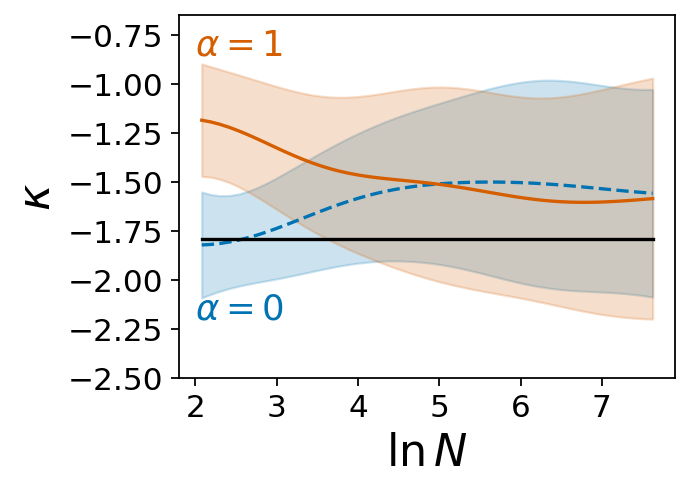

In [14]:
# data
X = x_train
Ydiff = y_train-t_train

# predictions
Xnew0 = np.array([np.linspace(np.log(8), np.log(1024*2), 50),
                 np.ones(50)*0.]).transpose()
Xnew1 = np.array([np.linspace(np.log(8), np.log(1024*2), 50),
                 np.ones(50)*1.]).transpose()
constant = model_param.mean_function.c.numpy()

# get predictions
meanA0, varA0, meanB0, varB0 = GPR_param_contributions(
    Xnew0, X, Ydiff, model_param)
meanA1, varA1, meanB1, varB1 = GPR_param_contributions(
    Xnew1, X, Ydiff, model_param)

# plot
figure(figsize=(4, 3), dpi=160)

plt.plot(Xnew0[:, 0], meanB0+np.log(1/6), '--',
         color=cmap[0])  # ,label='lambda=0')
plt.fill_between(
    Xnew0[:, 0],
    (meanB0[:, 0] - 1.96 * np.sqrt(varB0) + np.log(1/6)),
    (meanB0[:, 0] + 1.96 * np.sqrt(varB0) + np.log(1/6)),
    color=cmap[0],
    alpha=0.2,
)

plt.plot(Xnew1[:, 0], meanB1+np.log(1/6), color=cmap[3])  # ,label='lambda=0')
plt.fill_between(
    Xnew1[:, 0],
    (meanB1[:, 0] - 1.96 * np.sqrt(varB1) + np.log(1/6)),
    (meanB1[:, 0] + 1.96 * np.sqrt(varB1) + np.log(1/6)),
    color=cmap[3],
    alpha=0.2,
)

plt.plot(Xnew0[:, 0], Xnew0[:, 0]*0+np.log(1/6), color="k")

plt.xlabel(r'$\ln N$', fontsize=20)
plt.ylabel(r'$\kappa$', fontsize=20)
# plt.legend(fontsize=20)
plt.ylim([-.8-1.7, 1-1.7+.05])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.text(2,-0.85+np.log(1/6)+constant,'(a)',fontsize=16)

plt.text(2, -.65+np.log(1/6)+constant,
         r'$\alpha=0$', fontsize=16, color=cmap[0])
plt.text(2, .7+np.log(1/6)+constant, r'$\alpha=1$', fontsize=16, color=cmap[3])
plt.savefig('kappa_homo.pdf', bbox_inches='tight')
plt.show()

## Look at $\nu[\alpha]$ in $\ln R_g^2 = 2\nu[\alpha] \ln N + \kappa[\alpha,\ln N]$ 
We find that the predictions for $\nu$ include the the known values (stars) at the limits of $\alpha=0$ and $\alpha=1$.

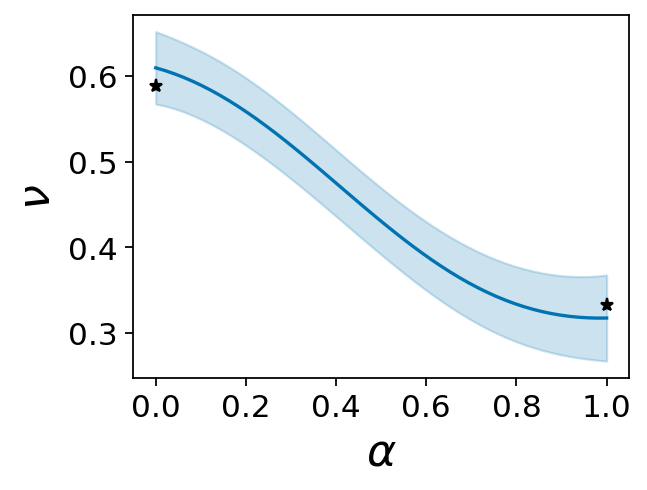

In [15]:
# data
X = x_train
Ydiff = y_train-t_train

# predictions
Xnew = np.array([np.ones(50)*np.log(512), np.linspace(0, 1, 50)]).transpose()

# get predictions
meanA, varA, meanB, varB = GPR_param_contributions(Xnew, X, Ydiff, model_param)

# plot
figure(figsize=(4, 3), dpi=160)

# 2 nu[\alpha] ln N = GP(0, (ln N) k_nu(alpha,alpha') (ln N')) + ln N
plt.plot(Xnew[:, 1], (meanA/np.log(512)+1)/2, color=cmap[0])
plt.fill_between(
    Xnew[:, 1],
    ((meanA[:, 0]/np.log(512)+1)/2 - 1.96 * np.sqrt(varA)/np.log(512)/2),
    ((meanA[:, 0]/np.log(512)+1)/2 + 1.96 * np.sqrt(varA)/np.log(512)/2),
    color=cmap[0],
    alpha=0.2,
)

plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\nu$', fontsize=20)
plt.plot([0, 1], [.588, .333], '*', color='black')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.text(0,.27,'(b)',fontsize=16)
plt.savefig('nu_homo.pdf', bbox_inches='tight')
plt.show()